In [1]:
!pip install praat-parselmouth

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import IPython.display as ipd
import soundfile as sf
import glob
import parselmouth
from parselmouth.praat import call
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier ,GradientBoostingClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score ,recall_score,precision_score,f1_score
from sklearn.model_selection import KFold, cross_val_score,train_test_split
import seaborn as sns
from random import randint
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import librosa
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
!unzip /content/drive/MyDrive/Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/MDVRKCL/Readtext/healthy/ID14_hc_0_2_12.wav  
  inflating: Dataset/MDVRKCL/Readtext/healthy/ID14_hc_0_2_13.wav  
  inflating: Dataset/MDVRKCL/Readtext/healthy/ID14_hc_0_2_14.wav  
  inflating: Dataset/MDVRKCL/Readtext/healthy/ID14_hc_0_2_15.wav  
  inflating: Dataset/MDVRKCL/Readtext/healthy/ID14_hc_0_2_16.wav  
  inflating: Dataset/MDVRKCL/Readtext/healthy/ID14_hc_0_2_17.wav  
  inflating: Dataset/MDVRKCL/Readtext/healthy/ID14_hc_0_2_18.wav  
  inflating: Dataset/MDVRKCL/Readtext/healthy/ID14_hc_0_2_19.wav  
  inflating: Dataset/MDVRKCL/Readtext/healthy/ID14_hc_0_2_2.wav  
  inflating: Dataset/MDVRKCL/Readtext/healthy/ID14_hc_0_2_20.wav  
  inflating: Dataset/MDVRKCL/Readtext/healthy/ID14_hc_0_2_21.wav  
  inflating: Dataset/MDVRKCL/Readtext/healthy/ID14_hc_0_2_22.wav  
  inflating: Dataset/MDVRKCL/Readtext/healthy/ID14_hc_0_2_23.wav  
  inflating: Dataset/MDVRKCL/Readtext/healthy/ID14_hc_0_2_24.wav  
  inflating:

In [3]:



class SNRSegmenter(object):

    def __init__(self, sample_rate, segment_len_ms, hop_len_ms, noise_len_ms, call_snr):
        self.segment_len_samples = int(sample_rate * segment_len_ms / 1000)
        self.hop_len_samples = int(sample_rate * hop_len_ms / 1000)
        self.noise_len_samples = int(sample_rate * noise_len_ms / 1000)

        self.call_snr = call_snr

    def _get_noise_level(self, sample):
        abs_max = []

        if len(sample) > self.noise_len_samples:
            idx = 0
            while idx + self.noise_len_samples < len(sample):
                abs_max.append(np.max(np.abs(sample[idx:(idx+self.noise_len_samples)])))
                idx += self.noise_len_samples
        else:
            abs_max.append(np.max(np.abs(sample)))

        return min(abs_max)

    def __call__(self, sample):

        noise_level = self._get_noise_level(sample)

        call_segments = []
        call_snrs = []

        if len(sample) > self.segment_len_samples:
            idx = 0
            while idx + self.segment_len_samples < len(sample):
                segment = sample[idx:(idx+self.segment_len_samples)]
                seg_abs_max = np.max(np.abs(segment))
                if seg_abs_max / noise_level > self.call_snr:
                    call_segments.append(segment)
                    call_snrs.append(seg_abs_max / noise_level)

                idx += self.hop_len_samples

        return call_segments, call_snrs



In [4]:
# import os

# directory_path = "C:/Users/Vishal/Desktop/btps8e02/Dataset/MDVRKCL/SpontaneousDialogue"

# path2 = "C:/Users/Vishal/Desktop/btps8e02/Codes/SBSSS/Dataset/MDVRKCL/SpontaneousDialogue"


# root = os.listdir(directory_path)

# for entry in root:
#     # print(entry)
#     subdir_path = os.path.join(directory_path, entry) #  create the absolute path of the subdir
#     subdir_path2 = os.path.join(path2, entry)
#     # print(subdir_path)
#     if os.path.isdir(subdir_path):  # check if it is a folder
#         subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
#         for subentry in subdir_entries:
#             wav_file = os.path.join(subdir_path, subentry)  # absolute path of the subentry
#             y, sample_rate = librosa.load(wav_file)
#             # Calculate the current DC offset (mean of the audio signal)
#             dc_offset = np.mean(y)

# # Apply the DC shift
#             y_shifted = y - dc_offset

#             audio = librosa.util.normalize(y_shifted)
#             segment_len_ms = 2500
#             hop_len_ms = 1000
#             noise_len_ms = 500
#             call_snr_thresh = 15

#             segmenter = SNRSegmenter(sample_rate, segment_len_ms, hop_len_ms, noise_len_ms, call_snr_thresh)

#             calls, call_snrs = segmenter(audio)
#             h=1
#             for i in calls:
#                 # if len(subentry)>18:
#                 #     temp = subentry[:9]+ "_2_"
#                 # else:
#                 #     temp = subentry[:9]+ "_1_"
#                 file = os.path.join(subdir_path2,subentry[:9]+ "_" )
#                 # if(subentry[:4]=='ID05'):
#                 #     print(len(subentry))
#                 #     print(file)
#                 sf.write(file+str(h)+".wav",i,sample_rate)
#                 h = h+1


In [5]:
# import os

# directory_path = "C:/Users/Vishal/Desktop/btps8e02/Dataset/MDVRKCL/Readtext"

# path2 = "C:/Users/Vishal/Desktop/btps8e02/Codes/SBSSS/Dataset/MDVRKCL/Readtext"


# root = os.listdir(directory_path)

# for entry in root:
#     # print(entry)
#     subdir_path = os.path.join(directory_path, entry) #  create the absolute path of the subdir
#     subdir_path2 = os.path.join(path2, entry)
#     # print(subdir_path)
#     if os.path.isdir(subdir_path):  # check if it is a folder
#         subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
#         for subentry in subdir_entries:
#             wav_file = os.path.join(subdir_path, subentry)  # absolute path of the subentry
#             y, sample_rate = librosa.load(wav_file)
#             # Calculate the current DC offset (mean of the audio signal)
#             dc_offset = np.mean(y)

# # Apply the DC shift
#             y_shifted = y - dc_offset

#             audio = librosa.util.normalize(y_shifted)
#             segment_len_ms = 2500
#             hop_len_ms = 1000
#             noise_len_ms = 500
#             call_snr_thresh = 5

#             segmenter = SNRSegmenter(sample_rate, segment_len_ms, hop_len_ms, noise_len_ms, call_snr_thresh)

#             calls, call_snrs = segmenter(audio)
#             h=1
#             for i in calls:
#                 if len(subentry)>18:
#                     temp = subentry[:9]+ "_2_"
#                 else:
#                     temp = subentry[:9]+ "_1_"
#                 file = os.path.join(subdir_path2, temp)
#                 # if(subentry[:4]=='ID05'):
#                 #     print(len(subentry))
#                 #     print(file)
#                 sf.write(file+str(h)+".wav",i,sample_rate)
#                 h = h+1


In [6]:
def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)


    return meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer

In [7]:
def runPCA(df):
    #Z-score the Jitter and Shimmer measurements
    features = ['localJitter', 'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
                'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer']
    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the target
    #y = df.loc[:,['target']].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    #PCA
    pca = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('pca', PCA(n_components=2))  # Perform PCA
])
    # pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['JitterPCA', 'ShimmerPCA'])
    principalDf
    return principalDf

In [ ]:
# create lists to put the results
file_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list = []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list = []
disease=[]
mfcc =[]


directory_path = "/home/iitg/Desktop/vishal/Dataset/MDVRKCL/Readtext"
root = os.listdir(directory_path)

for entry in root:
    # print(entry)
    subdir_path = os.path.join(directory_path, entry) #  create the absolute path of the subdir
     # print(subdir_path)
    if os.path.isdir(subdir_path):  # check if it is a folder
        subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
        for subentry in subdir_entries:
            wav_file = os.path.join(subdir_path, subentry)
            sound = parselmouth.Sound(wav_file)
            (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(sound, 75, 500, "Hertz")
            file_list.append(subentry) # make an ID list
            mean_F0_list.append(meanF0) # make a mean F0 list
            sd_F0_list.append(stdevF0) # make a sd F0 list
            hnr_list.append(hnr)
            localJitter_list.append(localJitter)
            localabsoluteJitter_list.append(localabsoluteJitter)
            rapJitter_list.append(rapJitter)
            ppq5Jitter_list.append(ppq5Jitter)
            ddpJitter_list.append(ddpJitter)
            localShimmer_list.append(localShimmer)
            localdbShimmer_list.append(localdbShimmer)
            apq3Shimmer_list.append(apq3Shimmer)
            aqpq5Shimmer_list.append(aqpq5Shimmer)
            apq11Shimmer_list.append(apq11Shimmer)
            ddaShimmer_list.append(ddaShimmer)
            if(subentry[5] == 'p'):
                disease.append(1)
            else:
                disease.append(0)
            sample , rate = librosa.load(wav_file)
            mfc = librosa.feature.mfcc(y= sample, sr= rate,n_mfcc =13)
            mfcc.append(mfc)

 #adding the lists to pandas in the right order
data = pd.DataFrame(np.column_stack([file_list, mean_F0_list, sd_F0_list, hnr_list, localJitter_list, rapJitter_list, localabsoluteJitter_list, ppq5Jitter_list, ddpJitter_list, localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, apq11Shimmer_list, ddaShimmer_list,disease]),
                               columns=['voiceID', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter',  'rapJitter','localabsoluteJitter',
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer',
                                        'apq11Shimmer', 'ddaShimmer','health_status'])


In [ ]:
data

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status
0,ID30_pd_2_1_21.wav,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,1
1,ID07_pd_2_1_32.wav,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,1
2,ID06_pd_3_1_39.wav,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1
3,ID02_pd_2_1_54.wav,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,1
4,ID04_pd_2_1_45.wav,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_32.wav,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,0
3945,ID09_hc_0_1_10.wav,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,0
3946,ID12_hc_0_1_77.wav,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,0
3947,ID15_hc_0_2_10.wav,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0


In [ ]:
mfcc

[array([[-137.63248  , -181.28094  , -224.67902  , ..., -413.0813   ,
         -424.08334  , -442.23984  ],
        [ 128.34285  ,  118.10777  ,  105.71268  , ...,   96.77724  ,
           91.463684 ,   78.8448   ],
        [  38.498787 ,   45.495644 ,   29.111732 , ...,   27.876432 ,
           36.768314 ,   44.07785  ],
        ...,
        [ -16.05609  ,  -24.388351 ,  -28.534157 , ...,   -4.0523133,
           -3.0781205,    1.734498 ],
        [ -13.9686575,  -15.626026 ,  -20.81527  , ...,   -2.3662477,
           -2.3242154,    4.232193 ],
        [ -12.335002 ,  -16.112593 ,  -13.207369 , ...,   14.166093 ,
           11.534737 ,   10.436373 ]], dtype=float32),
 array([[-2.6943027e+02, -2.4388945e+02, -2.3886441e+02, ...,
         -1.4317307e+02, -9.4835449e+01, -8.3100822e+01],
        [ 1.2445000e+02,  1.1345097e+02,  1.0816287e+02, ...,
          6.2542744e+00,  9.1374115e+01,  1.3890916e+02],
        [ 3.5358643e+01,  2.2600462e+01,  6.7384024e+00, ...,
          1.0200871e

In [ ]:
np.shape(mfcc)

(3949, 13, 108)

In [ ]:
# sample , rate = librosa.load("C:/Users/Vishal/Desktop/btps8e02/Codes/SBSSS/Dataset/MDVRKCL/Readtext/disease/ID02_pd_2_1_1.wav")
# m = librosa.feature.mfcc(y= sample, sr= rate,n_mfcc =13)
# np.shape(m)

In [ ]:
# mf = []
# mf.append(m)
# mf.append(m)

In [ ]:
# mf

In [8]:
# create lists to put the results
file_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list= []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list= []
disease=[]
mfcc1 =[]


directory_path1 = "/home/iitg/Desktop/vishal/Dataset/MDVRKCL/SpontaneousDialogue"
root1 = os.listdir(directory_path1)

for entry in root1:
    # print(entry)
    subdir_path = os.path.join(directory_path1, entry) #  create the absolute path of the subdir
     # print(subdir_path)
    if os.path.isdir(subdir_path):  # check if it is a folder
        subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
        for subentry in subdir_entries:
            wav_file = os.path.join(subdir_path, subentry)
            sound = parselmouth.Sound(wav_file)
            (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(sound, 75, 500, "Hertz")
            file_list.append(subentry) # make an ID list
            mean_F0_list.append(meanF0) # make a mean F0 list
            sd_F0_list.append(stdevF0) # make a sd F0 list
            hnr_list.append(hnr)
            localJitter_list.append(localJitter)
            localabsoluteJitter_list.append(localabsoluteJitter)
            rapJitter_list.append(rapJitter)
            ppq5Jitter_list.append(ppq5Jitter)
            ddpJitter_list.append(ddpJitter)
            localShimmer_list.append(localShimmer)
            localdbShimmer_list.append(localdbShimmer)
            apq3Shimmer_list.append(apq3Shimmer)
            aqpq5Shimmer_list.append(aqpq5Shimmer)
            apq11Shimmer_list.append(apq11Shimmer)
            ddaShimmer_list.append(ddaShimmer)
            if(subentry[5] == 'p'):
                disease.append(1)
            else:
                disease.append(0)
            sample , rate = librosa.load(wav_file)
            mfc = librosa.feature.mfcc(y= sample, sr= rate,n_mfcc =13)
            mfcc1.append(mfc)
 #adding the lists to pandas in the right order
data1 = pd.DataFrame(np.column_stack([file_list, mean_F0_list, sd_F0_list, hnr_list, localJitter_list, rapJitter_list, localabsoluteJitter_list, ppq5Jitter_list, ddpJitter_list, localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, apq11Shimmer_list, ddaShimmer_list,disease]),
                               columns=['voiceID', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter',  'rapJitter','localabsoluteJitter',
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer',
                                        'apq11Shimmer', 'ddaShimmer','health_status'])


In [ ]:
data1

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status
0,ID07_pd_2_33.wav,131.157619087346,18.41974005342744,12.950104849829128,0.03377358591505507,0.014056251359204566,0.00025686853317184136,0.014067770840009458,0.042168754077613696,0.10688347703671161,1.1372001430436516,0.03902855382908773,0.06524264390798276,0.10633870420439866,0.11708566148726318,1
1,ID02_pd_2_35.wav,130.33530206299983,14.799851765283627,12.69491307410226,0.021892886655310872,0.01087414551306562,0.00016849237726369247,0.010976929057909113,0.03262243653919686,0.09870504829648656,0.8310082966317837,0.03206187901107961,0.04557312299002953,0.09798117904863585,0.09618563703323883,1
2,ID13_pd_3_130.wav,349.112353417843,116.75755585584562,8.364307455872076,0.0748515696236342,0.0405104463916406,0.00020864346137158926,0.06683498571135799,0.1215313391749218,0.20702896732798667,1.7851669337953946,0.08211635198932533,0.13551863831184058,nan,0.24634905596797602,1
3,ID04_pd_2_56.wav,121.66801792231911,68.05652236637023,10.630450797056433,0.05505443152077786,0.028143891273462604,0.0004727388183433783,0.024433503980055844,0.08443167382038781,0.1471923018888942,1.3399789723445452,0.07508641746753077,0.07248137941006336,0.15169557097443911,0.2252592524025923,1
4,ID13_pd_3_145.wav,156.9437142184571,33.186567155857205,11.543234169518175,0.024359735811875602,0.01130084324559137,0.00015626973222824557,0.013229378304494896,0.03390252973677411,0.10992311932988118,0.970749600079835,0.04260548116568773,0.05455484763792896,0.0893086662036813,0.12781644349706317,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,ID09_hc_0_77.wav,159.71944757028962,29.857711771703865,13.055988919628977,0.020652823968674454,0.009055039511916862,0.00013032680803252113,0.007381065116742844,0.027165118535750585,0.047855769525189155,0.4929829049849656,0.01953807335161132,0.02904217897542476,0.04403232969346928,0.05861422005483396,0
3627,ID12_hc_0_53.wav,186.06301734926376,92.67274573705933,12.403182420342969,0.019357460161675215,0.007398342273966874,0.00010312506668110936,0.0087838818583951,0.022195026821900624,0.07453229633346663,0.897176667288428,0.02948758968801221,0.04191819803059958,0.06871156229472386,0.08846276906403663,0
3628,ID01_hc_0_13.wav,180.75468747596497,12.59068361176198,13.218455158850704,0.018885590290725413,0.00830394315343727,0.00010469515479607999,0.009103373822757412,0.024911829460311806,0.0795122911186838,0.7640067542722503,0.023566720070558815,0.038586903610881775,0.09241410017310348,0.07070016021167644,0
3629,ID15_hc_0_69.wav,177.44804995588996,36.15398411826179,12.413206558293925,0.012278049065975533,0.004868338025998995,6.970079717158551e-05,0.0057005228577766826,0.014605014077996987,0.08102943187508477,0.734063503852381,0.032668861439448915,0.0432869565188665,0.08219016037569188,0.09800658431834675,0


In [ ]:
data

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status
0,ID30_pd_2_1_21.wav,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,1
1,ID07_pd_2_1_32.wav,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,1
2,ID06_pd_3_1_39.wav,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1
3,ID02_pd_2_1_54.wav,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,1
4,ID04_pd_2_1_45.wav,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_32.wav,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,0
3945,ID09_hc_0_1_10.wav,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,0
3946,ID12_hc_0_1_77.wav,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,0
3947,ID15_hc_0_2_10.wav,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0


In [9]:
null_values = data1.isnull().any()

In [ ]:

# Check for null values
null_values = data.isnull().any()

In [ ]:
null_values

voiceID                False
meanF0Hz               False
stdevF0Hz              False
HNR                    False
localJitter            False
rapJitter              False
localabsoluteJitter    False
ppq5Jitter             False
ddpJitter              False
localShimmer           False
localdbShimmer         False
apq3Shimmer            False
apq5Shimmer            False
apq11Shimmer           False
ddaShimmer             False
health_status          False
dtype: bool

In [10]:
pcaData1 = runPCA(data1)

In [ ]:
pcaData = runPCA(data)

In [11]:
data1 = pd.concat([data1, pcaData1], axis=1)

In [ ]:
data = pd.concat([data, pcaData], axis=1)

In [ ]:
data1

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID07_pd_2_33.wav,131.157619087346,18.41974005342744,12.950104849829128,0.03377358591505507,0.014056251359204566,0.00025686853317184136,0.014067770840009458,0.042168754077613696,0.10688347703671161,1.1372001430436516,0.03902855382908773,0.06524264390798276,0.10633870420439866,0.11708566148726318,1,0.526521,0.540670
1,ID02_pd_2_35.wav,130.33530206299983,14.799851765283627,12.69491307410226,0.021892886655310872,0.01087414551306562,0.00016849237726369247,0.010976929057909113,0.03262243653919686,0.09870504829648656,0.8310082966317837,0.03206187901107961,0.04557312299002953,0.09798117904863585,0.09618563703323883,1,-1.030476,0.193376
2,ID13_pd_3_130.wav,349.112353417843,116.75755585584562,8.364307455872076,0.0748515696236342,0.0405104463916406,0.00020864346137158926,0.06683498571135799,0.1215313391749218,0.20702896732798667,1.7851669337953946,0.08211635198932533,0.13551863831184058,nan,0.24634905596797602,1,8.341675,2.555712
3,ID04_pd_2_56.wav,121.66801792231911,68.05652236637023,10.630450797056433,0.05505443152077786,0.028143891273462604,0.0004727388183433783,0.024433503980055844,0.08443167382038781,0.1471923018888942,1.3399789723445452,0.07508641746753077,0.07248137941006336,0.15169557097443911,0.2252592524025923,1,4.593396,1.773577
4,ID13_pd_3_145.wav,156.9437142184571,33.186567155857205,11.543234169518175,0.024359735811875602,0.01130084324559137,0.00015626973222824557,0.013229378304494896,0.03390252973677411,0.10992311932988118,0.970749600079835,0.04260548116568773,0.05455484763792896,0.0893086662036813,0.12781644349706317,1,-0.340829,-0.148487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,ID09_hc_0_77.wav,159.71944757028962,29.857711771703865,13.055988919628977,0.020652823968674454,0.009055039511916862,0.00013032680803252113,0.007381065116742844,0.027165118535750585,0.047855769525189155,0.4929829049849656,0.01953807335161132,0.02904217897542476,0.04403232969346928,0.05861422005483396,0,-2.774961,0.910908
3627,ID12_hc_0_53.wav,186.06301734926376,92.67274573705933,12.403182420342969,0.019357460161675215,0.007398342273966874,0.00010312506668110936,0.0087838818583951,0.022195026821900624,0.07453229633346663,0.897176667288428,0.02948758968801221,0.04191819803059958,0.06871156229472386,0.08846276906403663,0,-1.890727,-0.155475
3628,ID01_hc_0_13.wav,180.75468747596497,12.59068361176198,13.218455158850704,0.018885590290725413,0.00830394315343727,0.00010469515479607999,0.009103373822757412,0.024911829460311806,0.0795122911186838,0.7640067542722503,0.023566720070558815,0.038586903610881775,0.09241410017310348,0.07070016021167644,0,-2.018856,0.065413
3629,ID15_hc_0_69.wav,177.44804995588996,36.15398411826179,12.413206558293925,0.012278049065975533,0.004868338025998995,6.970079717158551e-05,0.0057005228577766826,0.014605014077996987,0.08102943187508477,0.734063503852381,0.032668861439448915,0.0432869565188665,0.08219016037569188,0.09800658431834675,0,-2.394072,-0.840474


In [ ]:
data

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID30_pd_2_1_21.wav,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,1,-3.818259,-1.113315
1,ID07_pd_2_1_32.wav,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,1,0.089032,0.243760
2,ID06_pd_3_1_39.wav,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1,1.030741,-1.651302
3,ID02_pd_2_1_54.wav,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,1,-1.524265,-0.206816
4,ID04_pd_2_1_45.wav,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,1,9.231832,-1.410365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_32.wav,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,0,5.288916,-0.697171
3945,ID09_hc_0_1_10.wav,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,0,-1.471152,-0.765124
3946,ID12_hc_0_1_77.wav,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,0,-0.518949,-0.072998
3947,ID15_hc_0_2_10.wav,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0,0.089318,0.720074


In [ ]:
data.describe()

,JitterPCA,ShimmerPCA
count,3.949000e+03,3.949000e+03
mean,3.166764e-16,2.249122e-16
std,2.865305e+00,1.194834e+00
min,-5.667275e+00,-7.959300e+00
25%,-1.908328e+00,-6.722464e-01
50%,-4.667666e-01,1.729023e-02
75%,1.263983e+00,6.830334e-01
max,2.116857e+01,8.829128e+00


In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
# data1.to_csv("extracted_features_spontaneous.csv", index=False)

In [ ]:
# data.to_csv("extracted_features.csv", index=False)

In [ ]:
data.isnull().values.sum()

0

In [ ]:
data

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID30_pd_2_1_21.wav,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,1,-3.818259,-1.113315
1,ID07_pd_2_1_32.wav,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,1,0.089032,0.243760
2,ID06_pd_3_1_39.wav,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1,1.030741,-1.651302
3,ID02_pd_2_1_54.wav,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,1,-1.524265,-0.206816
4,ID04_pd_2_1_45.wav,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,1,9.231832,-1.410365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_32.wav,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,0,5.288916,-0.697171
3945,ID09_hc_0_1_10.wav,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,0,-1.471152,-0.765124
3946,ID12_hc_0_1_77.wav,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,0,-0.518949,-0.072998
3947,ID15_hc_0_2_10.wav,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0,0.089318,0.720074


In [ ]:
#Looking at dataset¶
# data_pd = pd.read_csv("./extracted_features.csv")

data_pd = data.copy()

In [12]:
#Looking at dataset¶
# data_pd1 = pd.read_csv("./extracted_features_spontaneous.csv")
data_pd1 = data1.copy()

In [ ]:
data_pd

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID30_pd_2_1_21.wav,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,1,-3.818259,-1.113315
1,ID07_pd_2_1_32.wav,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,1,0.089032,0.243760
2,ID06_pd_3_1_39.wav,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1,1.030741,-1.651302
3,ID02_pd_2_1_54.wav,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,1,-1.524265,-0.206816
4,ID04_pd_2_1_45.wav,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,1,9.231832,-1.410365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_32.wav,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,0,5.288916,-0.697171
3945,ID09_hc_0_1_10.wav,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,0,-1.471152,-0.765124
3946,ID12_hc_0_1_77.wav,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,0,-0.518949,-0.072998
3947,ID15_hc_0_2_10.wav,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0,0.089318,0.720074


In [ ]:
data_pd

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID30_pd_2_1_21.wav,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,1,-3.818259,-1.113315
1,ID07_pd_2_1_32.wav,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,1,0.089032,0.243760
2,ID06_pd_3_1_39.wav,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1,1.030741,-1.651302
3,ID02_pd_2_1_54.wav,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,1,-1.524265,-0.206816
4,ID04_pd_2_1_45.wav,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,1,9.231832,-1.410365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_32.wav,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,0,5.288916,-0.697171
3945,ID09_hc_0_1_10.wav,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,0,-1.471152,-0.765124
3946,ID12_hc_0_1_77.wav,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,0,-0.518949,-0.072998
3947,ID15_hc_0_2_10.wav,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0,0.089318,0.720074


In [13]:
data_pd1

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID16_pd_2_17.wav,210.40031556820227,24.646833970281577,10.668780914086982,0.03352003044785116,0.014502855112618122,0.0001604455045722061,0.01883646475164346,0.04350856533785437,0.10951037190156815,1.0097796630499434,0.04172986737459425,0.062032214197985394,0.10463100696347467,0.12518960212378274,1,0.438572,0.396083
1,ID07_pd_2_68.wav,143.07602378284048,68.48918776596544,12.667750469944039,0.030492633708365677,0.010739084119023906,0.0002168875598281908,0.014013646465297673,0.03221725235707172,0.13313600658512745,1.3216190053115953,0.05729554801008228,0.07991530300745277,0.33181855324373266,0.17188664403024684,1,1.821329,-1.739087
2,ID04_pd_2_15.wav,103.478291425241,9.65345427052407,10.134480156966719,0.029708902276541525,0.012314341577080693,0.0002867409864189196,0.014439597712422777,0.03694302473124208,0.11164228375960192,1.0985461587874374,0.04043716487866125,0.06576390091233379,0.1379217408956524,0.12131149463598376,1,0.525990,0.257836
3,ID24_pd_2_49.wav,468.3902700852919,13.080880146084807,0.9211672469789697,0.06940297027919086,0.038509201460806476,0.0001464153662344025,0.048811371872622335,0.11552760438241944,0.2243577875322107,1.8512418559929873,0.15416540475496368,0.07524044467145126,nan,0.46249621426489107,1,8.857732,-0.070876
4,ID04_pd_2_45.wav,117.20295778610654,57.12933490856327,8.993997649709522,0.039692322688224535,0.018400985976983274,0.00034243950989855685,0.01823057678790025,0.05520295793094982,0.11854062277838742,1.0747149952113169,0.04860622511665444,0.06234809694306142,0.06269642158080314,0.14581867534996332,1,1.444405,1.412440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,ID10_hc_0_50.wav,174.22409456215786,63.057157118436145,8.449937624298494,0.040380949039514454,0.020993449241165085,0.00023505082850683263,0.017473283683731376,0.06298034772349526,0.12321006775623762,1.1323749220805464,0.052195113576672954,0.07861955100376891,0.10942797144051339,0.15658534073001887,0,1.872502,0.710997
3627,ID11_hc_0_45.wav,287.647319601689,40.93127595790085,13.834640337741922,0.017905820323927724,0.0076247745687611,6.217221086381737e-05,0.010368933750789724,0.022874323706283298,0.06288970314946671,0.6016971902459329,0.021219906110336754,0.028340827328355012,0.032631082722559955,0.06365971833101026,0,-2.772615,0.451826
3628,ID25_hc_0_93.wav,198.86678121010507,33.20505006798829,17.540042313576492,0.015688903364853686,0.007880194852757077,7.962911856270466e-05,0.0081782783610524,0.02364058455827123,0.06378259087151646,0.7335068980170928,0.024688201413617945,0.03775356308595011,0.06641993037183633,0.07406460424085384,0,-2.418349,0.010263
3629,ID23_hc_0_40.wav,161.00131881725247,13.012056070071292,14.365688780681134,0.00999293168817718,0.0036639972422816166,6.19876907768976e-05,0.004471065178480323,0.01099199172684485,0.03916663246874114,0.4768646024468889,0.012091052240442513,0.01721620930292137,0.03624606804285323,0.03627315672132754,0,-4.086844,0.272419


In [14]:
data_pd1.isnull().values.sum()

0

In [ ]:
data_pd.isnull().values.sum()

0

In [15]:
data_pd1 = data_pd1.dropna()
data_pd1.drop(["voiceID"],axis =1,inplace =True)

In [ ]:
data_pd = data_pd.dropna()

In [ ]:
data_pd.drop(["voiceID"],axis =1,inplace =True)

In [16]:
data_pd1.reset_index(drop=True, inplace=True)
data_pd1.isnull().values.sum()

0

In [17]:
data_pd1

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,210.40031556820227,24.646833970281577,10.668780914086982,0.03352003044785116,0.014502855112618122,0.0001604455045722061,0.01883646475164346,0.04350856533785437,0.10951037190156815,1.0097796630499434,0.04172986737459425,0.062032214197985394,0.10463100696347467,0.12518960212378274,1,0.438572,0.396083
1,143.07602378284048,68.48918776596544,12.667750469944039,0.030492633708365677,0.010739084119023906,0.0002168875598281908,0.014013646465297673,0.03221725235707172,0.13313600658512745,1.3216190053115953,0.05729554801008228,0.07991530300745277,0.33181855324373266,0.17188664403024684,1,1.821329,-1.739087
2,103.478291425241,9.65345427052407,10.134480156966719,0.029708902276541525,0.012314341577080693,0.0002867409864189196,0.014439597712422777,0.03694302473124208,0.11164228375960192,1.0985461587874374,0.04043716487866125,0.06576390091233379,0.1379217408956524,0.12131149463598376,1,0.525990,0.257836
3,468.3902700852919,13.080880146084807,0.9211672469789697,0.06940297027919086,0.038509201460806476,0.0001464153662344025,0.048811371872622335,0.11552760438241944,0.2243577875322107,1.8512418559929873,0.15416540475496368,0.07524044467145126,nan,0.46249621426489107,1,8.857732,-0.070876
4,117.20295778610654,57.12933490856327,8.993997649709522,0.039692322688224535,0.018400985976983274,0.00034243950989855685,0.01823057678790025,0.05520295793094982,0.11854062277838742,1.0747149952113169,0.04860622511665444,0.06234809694306142,0.06269642158080314,0.14581867534996332,1,1.444405,1.412440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,174.22409456215786,63.057157118436145,8.449937624298494,0.040380949039514454,0.020993449241165085,0.00023505082850683263,0.017473283683731376,0.06298034772349526,0.12321006775623762,1.1323749220805464,0.052195113576672954,0.07861955100376891,0.10942797144051339,0.15658534073001887,0,1.872502,0.710997
3627,287.647319601689,40.93127595790085,13.834640337741922,0.017905820323927724,0.0076247745687611,6.217221086381737e-05,0.010368933750789724,0.022874323706283298,0.06288970314946671,0.6016971902459329,0.021219906110336754,0.028340827328355012,0.032631082722559955,0.06365971833101026,0,-2.772615,0.451826
3628,198.86678121010507,33.20505006798829,17.540042313576492,0.015688903364853686,0.007880194852757077,7.962911856270466e-05,0.0081782783610524,0.02364058455827123,0.06378259087151646,0.7335068980170928,0.024688201413617945,0.03775356308595011,0.06641993037183633,0.07406460424085384,0,-2.418349,0.010263
3629,161.00131881725247,13.012056070071292,14.365688780681134,0.00999293168817718,0.0036639972422816166,6.19876907768976e-05,0.004471065178480323,0.01099199172684485,0.03916663246874114,0.4768646024468889,0.012091052240442513,0.01721620930292137,0.03624606804285323,0.03627315672132754,0,-4.086844,0.272419


In [ ]:
data_pd.isnull().values.sum()

0

In [ ]:
data_pd.reset_index(drop=True, inplace=True)

In [ ]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,1,-3.818259,-1.113315
1,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,1,0.089032,0.243760
2,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1,1.030741,-1.651302
3,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,1,-1.524265,-0.206816
4,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,1,9.231832,-1.410365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,0,5.288916,-0.697171
3945,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,0,-1.471152,-0.765124
3946,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,0,-0.518949,-0.072998
3947,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0,0.089318,0.720074


In [ ]:
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# data_pd = pd.DataFrame(imputer.fit_transform(data_pd), columns=data_pd.columns)

In [ ]:
data_pd.isnull().values.sum()

0

In [18]:
label_pd1 = data_pd1["health_status"]
data_pd1.drop(["health_status"],axis = 1,inplace = True)

print("Parkinson's disease dataset:\n",data_pd1.shape[0],"Records\n",data_pd1.shape[1],"Features")

Parkinson's disease dataset:
 3631 Records
 16 Features


In [ ]:


label_pd = data_pd["health_status"]
data_pd.drop(["health_status"],axis = 1,inplace = True)

print("Parkinson's disease dataset:\n",data_pd.shape[0],"Records\n",data_pd.shape[1],"Features")

Parkinson's disease dataset:
 3949 Records
 16 Features


In [ ]:
type(data_pd)

pandas.core.frame.DataFrame

In [ ]:
type(label_pd[0])

str

In [19]:
def split(data_pd,label_pd):
    X_tr, X_te, Y_tr, Y_te = train_test_split(data_pd, label_pd, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

In [ ]:

X_train1,X_test1, Y_train1, Y_test1 = split(data_pd1,label_pd1)

In [ ]:

X_train,X_test, Y_train, Y_test = split(data_pd,label_pd)

In [ ]:
X_train

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
3633,135.93998319266123,23.479811281503252,10.700725975569142,0.029824524110053166,0.010249276411331545,0.00022110373615672052,0.008488855910990183,0.030747829233994634,0.0856614139063815,0.80190618013602,0.032543471624488056,0.048971402544529356,0.09046623199819906,0.09763041487346416,-1.071177,-0.591342
2031,195.49493516006024,16.297802509746678,13.645134999789374,0.018366735782740142,0.008621249081113875,9.413232240504411e-05,0.00930553364944513,0.025863747243341624,0.06840075956301941,0.7752184465787627,0.023238441803466348,0.038006145475311025,0.07288584977618863,0.06971532541039904,-2.902527,-0.386061
2507,159.69797093267726,39.19476748769988,12.419144203867829,0.027569663365288325,0.011611406962407369,0.00017355894300663096,0.0140971860121213,0.03483422088722211,0.07991896527346735,0.867046053397533,0.026259245365141657,0.039199002863593964,0.07184229637958979,0.07877773609542497,-1.282489,-1.344531
2406,132.90602496967873,8.262497125311668,8.381730852870996,0.030484586167244036,0.014337638914200139,0.000229174482298813,0.019942463056753942,0.04301291674260042,0.14260816138452218,1.1696178927527987,0.056515358973710926,0.07821583141448797,0.14074426277893828,0.16954607692113277,3.044692,0.775628
31,173.00316527966902,37.78318790378157,17.387214044679343,0.016449786909162375,0.00646209242887274,9.440021955694118e-05,0.008707853296437378,0.019386277286618223,0.07719812509326841,0.7124320926591874,0.031533678466676346,0.04493150470779746,0.0747204201294651,0.09460103540002904,-2.789320,0.368351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,193.80479362383127,44.1093094244959,15.685780396916336,0.0262738392549135,0.012010926283149786,0.00013663297646802734,0.013540631323929705,0.03603277884944936,0.11959474282953814,1.294881599557006,0.045982354945722205,0.0661180564630318,0.14157514184607373,0.13794706483716662,1.224459,1.360112
1294,133.48547748142082,13.583213063194096,11.775735628760009,0.024876993434253022,0.008963565648651695,0.0001867982746752749,0.010675635502956592,0.026890696945955084,0.10655455336087132,0.9864233787022436,0.036583005101446735,0.05402550357063301,0.09439295801128807,0.1097490153043402,-0.613244,0.381703
860,219.4299806833371,54.66893263236235,14.071716517097299,0.02046837373263488,0.008261607249661934,9.392667476427437e-05,0.00946053207316082,0.024784821748985802,0.07673237371877249,0.8161185042065622,0.023981443583664983,0.03951697715090787,0.07438159919122654,0.07194433075099495,-2.654142,-0.237606
3507,182.22948146422814,20.981163383927218,13.152653414382804,0.015054344812578769,0.006397265866034726,8.226269903587093e-05,0.006866902657421355,0.019191797598104177,0.07531396730310581,0.7896234857272888,0.026966958818182833,0.03597399501111965,0.060074205882399256,0.08090087645454849,-3.315271,0.208507


In [ ]:
Y_train

3633    0
2031    0
2507    0
2406    0
31      1
       ..
1130    1
1294    1
860     1
3507    0
3174    0
Name: health_status, Length: 2961, dtype: object

In [20]:
classifiers = ['LinearSVM', 'RadialSVM',
               'Logistic',  'RandomForest',
               'AdaBoost',  'DecisionTree',
               'KNeighbors','GradientBoosting',
               'XGBoost']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0),
          xgb.XGBClassifier(objective="reg:logistic", random_state=42)]

In [21]:
def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [35]:
import pandas as pd
def Evaluate(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    spec =[]
    sens = []
    prec =[]
    f_msr=[]
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        spec.append(recall_score(Y_test, predictions, pos_label=0))
        sens.append(recall_score(Y_test, predictions))
        prec.append(precision_score(Y_test, predictions))
        f_msr.append(f1_score(Y_test, predictions))
        j = j+1
    Score["Accuracy"] = acc
    Score["Specificity"] =spec
    Score["Sensitivity"] =sens
    Score["Precision"] = prec
    Score["F Measure"] =f_msr
    # Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    # Score.reset_index(drop=True, inplace=True)
    return Score

In [23]:
logmodel = xgb.XGBClassifier(objective="reg:logistic", random_state=42)

In [24]:
#To initialize a random population.
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool_)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)

    return population

#Returns the best parents along with their score.
def fitness_score(population , pd , mfc,label_pd):
    scores = []
    le = LabelEncoder()
    le.fit(label_pd)
    label = le.transform(label_pd)
    tr =0
    for chromosome in population:
        # print(chromosome)
        jh =0
        dr = []
        count =0
        for ig in chromosome:
            if ig == True:
                count = count + 1
                if jh >15:
                    # print(np.shape(mfc[ : , jh-16, : ]))
                    dr= np.concatenate((dr, mfc[ : , jh-16, : ]), axis=1)
                else:
                    dr.append(np.array(pd[ : ,jh]))
                    # print(np.shape(dr))

            # dr = np.vstack((dr, np.array(pd[ : ,jh])))
            if jh ==15:
                dr = np.transpose(dr)
                # print(np.shape(dr))
            jh =jh+1
        # dre = np.transpose(dr
        tr = tr+1
        print(tr)


        # np.shape(dr)
        X_train,X_test, Y_train, Y_test = split(dr,label)
        logmodel.fit(X_train,Y_train)
        predictions = logmodel.predict(X_test)
        print(np.shape(dr))
        scores.append(accuracy_score(Y_test,predictions))

    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

#Selection of the best parents.
def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents*2):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

# Picks half of the first parent and half of the second parent withy crossover rate of 0.5.
def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

#Randomly flips selected bits from the crossover child.
def mutation(pop_after_cross,mutation_rate,n_feat):
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = []
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(label_pd , size,n_feat,n_parents,mutation_rate,n_gen,pd ,mfc):
    best_chromo= []
    best_score =0
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen , pd ,mfc,label_pd)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        print(scores[:10])
        if(scores[0]>best_score):
            best_chromo = pop_after_fit[0]
            best_score = scores[0]
        # best_chromo.append(pop_after_fit[0])
        # best_score.append(scores[0])
    return best_chromo,best_score

In [ ]:
int(0.18*17)

3

In [ ]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,-3.818259,-1.113315
1,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,0.089032,0.243760
2,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1.030741,-1.651302
3,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,-1.524265,-0.206816
4,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,9.231832,-1.410365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,5.288916,-0.697171
3945,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,-1.471152,-0.765124
3946,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,-0.518949,-0.072998
3947,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0.089318,0.720074


In [ ]:
data_pd.isnull().values.any()

False

In [ ]:
label_pd.isnull().values.any()

False

In [ ]:
type(data_pd)

pandas.core.frame.DataFrame

In [ ]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,-3.818259,-1.113315
1,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,0.089032,0.243760
2,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1.030741,-1.651302
3,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,-1.524265,-0.206816
4,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,9.231832,-1.410365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,5.288916,-0.697171
3945,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,-1.471152,-0.765124
3946,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,-0.518949,-0.072998
3947,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0.089318,0.720074


In [ ]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# data_pd = imputer.fit_transform(data_pd)

In [ ]:
def init(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool_)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

In [ ]:
label_pd1

0       1
1       1
2       1
3       1
4       1
       ..
3626    0
3627    0
3628    0
3629    0
3630    0
Name: health_status, Length: 3631, dtype: object

In [ ]:
# le = LabelEncoder()
# le.fit(label_pd1)
# y = le.transform(label_pd1)

In [ ]:
# pop = init(100 , 29)
# pop

In [ ]:
# sc , pope  = f_score(pop,pd,mfcc)

In [ ]:
# # df
# score1 = Evaluate(data_pd,label_pd)
# score1


In [ ]:
# df.isnull().values.any()

In [25]:
data_pd1

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,210.40031556820227,24.646833970281577,10.668780914086982,0.03352003044785116,0.014502855112618122,0.0001604455045722061,0.01883646475164346,0.04350856533785437,0.10951037190156815,1.0097796630499434,0.04172986737459425,0.062032214197985394,0.10463100696347467,0.12518960212378274,0.438572,0.396083
1,143.07602378284048,68.48918776596544,12.667750469944039,0.030492633708365677,0.010739084119023906,0.0002168875598281908,0.014013646465297673,0.03221725235707172,0.13313600658512745,1.3216190053115953,0.05729554801008228,0.07991530300745277,0.33181855324373266,0.17188664403024684,1.821329,-1.739087
2,103.478291425241,9.65345427052407,10.134480156966719,0.029708902276541525,0.012314341577080693,0.0002867409864189196,0.014439597712422777,0.03694302473124208,0.11164228375960192,1.0985461587874374,0.04043716487866125,0.06576390091233379,0.1379217408956524,0.12131149463598376,0.525990,0.257836
3,468.3902700852919,13.080880146084807,0.9211672469789697,0.06940297027919086,0.038509201460806476,0.0001464153662344025,0.048811371872622335,0.11552760438241944,0.2243577875322107,1.8512418559929873,0.15416540475496368,0.07524044467145126,nan,0.46249621426489107,8.857732,-0.070876
4,117.20295778610654,57.12933490856327,8.993997649709522,0.039692322688224535,0.018400985976983274,0.00034243950989855685,0.01823057678790025,0.05520295793094982,0.11854062277838742,1.0747149952113169,0.04860622511665444,0.06234809694306142,0.06269642158080314,0.14581867534996332,1.444405,1.412440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,174.22409456215786,63.057157118436145,8.449937624298494,0.040380949039514454,0.020993449241165085,0.00023505082850683263,0.017473283683731376,0.06298034772349526,0.12321006775623762,1.1323749220805464,0.052195113576672954,0.07861955100376891,0.10942797144051339,0.15658534073001887,1.872502,0.710997
3627,287.647319601689,40.93127595790085,13.834640337741922,0.017905820323927724,0.0076247745687611,6.217221086381737e-05,0.010368933750789724,0.022874323706283298,0.06288970314946671,0.6016971902459329,0.021219906110336754,0.028340827328355012,0.032631082722559955,0.06365971833101026,-2.772615,0.451826
3628,198.86678121010507,33.20505006798829,17.540042313576492,0.015688903364853686,0.007880194852757077,7.962911856270466e-05,0.0081782783610524,0.02364058455827123,0.06378259087151646,0.7335068980170928,0.024688201413617945,0.03775356308595011,0.06641993037183633,0.07406460424085384,-2.418349,0.010263
3629,161.00131881725247,13.012056070071292,14.365688780681134,0.00999293168817718,0.0036639972422816166,6.19876907768976e-05,0.004471065178480323,0.01099199172684485,0.03916663246874114,0.4768646024468889,0.012091052240442513,0.01721620930292137,0.03624606804285323,0.03627315672132754,-4.086844,0.272419


In [ ]:
pd = np.array(data_pd)

In [ ]:
# chromosome = np.ones(29,dtype=np.bool_)
# chromosome[:int(0.3*29)]=False

# jh =0
# dr = []
# for ig in chromosome:
#     if ig == True:
#         if jh >15:

#             dr= np.concatenate((dr, mfc[ : , jh-16, : ]), axis=0)
#             print(np.shape(dr))
#         else:
#             dr.append(np.array(pd[ : ,jh]))
#             print(np.shape(dr))
#             #dr = np.vstack((dr, np.array(pd[ : ,jh])))


In [ ]:
# dr = np.transpose(dr)
# print(dr.shape)

In [26]:
chromo_df_pd1,score_pd1=generations(label_pd1 ,size=100,n_feat=29,n_parents=20,mutation_rate=0.1,n_gen=2, pd = np.array(data_pd1) , mfc = np.array(mfcc1)
                         )

1
(3631, 877)
2
(3631, 984)
3
(3631, 1198)
4
(3631, 1091)
5
(3631, 984)
6
(3631, 1198)
7
(3631, 877)
8
(3631, 1091)
9
(3631, 1091)
10
(3631, 1198)
11
(3631, 1091)
12
(3631, 984)
13
(3631, 877)
14
(3631, 1091)
15
(3631, 984)
16
(3631, 984)
17
(3631, 984)
18
(3631, 984)
19
(3631, 1091)
20
(3631, 1091)
21
(3631, 984)
22
(3631, 984)
23
(3631, 1305)
24
(3631, 1091)
25
(3631, 984)
26
(3631, 1091)
27
(3631, 984)
28
(3631, 984)
29
(3631, 877)
30
(3631, 1305)
31
(3631, 1198)
32
(3631, 1198)
33
(3631, 1091)
34
(3631, 1091)
35
(3631, 984)
36
(3631, 877)
37
(3631, 1198)
38
(3631, 877)
39
(3631, 1091)
40
(3631, 1198)
41
(3631, 984)
42
(3631, 984)
43
(3631, 877)
44
(3631, 1091)
45
(3631, 1198)
46
(3631, 984)
47
(3631, 1091)
48
(3631, 877)
49
(3631, 984)
50
(3631, 1091)
51
(3631, 984)
52
(3631, 1091)
53
(3631, 1091)
54
(3631, 1091)
55
(3631, 877)
56
(3631, 877)
57
(3631, 1198)
58
(3631, 1091)
59
(3631, 877)
60
(3631, 984)
61
(3631, 1198)
62
(3631, 1198)
63
(3631, 984)
64
(3631, 1091)
65
(3631, 877)
6

In [ ]:
#Apply Genetic Algorithm for feature selection
chromo_df_pd1,score_pd1=generations(label_pd1 ,size=100,n_feat=29,n_parents=20,mutation_rate=0.1,n_gen=20, pd = np.array(data_pd1) , mfc = np.array(mfcc1)
                         )

1
(3631, 770)
2
(3631, 1091)
3
(3631, 1198)
4
(3631, 877)
5
(3631, 984)
6
(3631, 984)
7
(3631, 1091)
8
(3631, 984)
9
(3631, 1091)
10
(3631, 877)
11
(3631, 1198)
12
(3631, 984)
13
(3631, 1091)
14
(3631, 1198)
15
(3631, 984)
16
(3631, 1091)
17
(3631, 984)
18
(3631, 877)
19
(3631, 984)
20
(3631, 1091)
21
(3631, 1091)
22
(3631, 1198)
23
(3631, 877)
24
(3631, 1198)
25
(3631, 984)
26
(3631, 984)
27
(3631, 1091)
28
(3631, 1305)
29
(3631, 770)
30
(3631, 984)
31
(3631, 984)
32
(3631, 1091)
33
(3631, 984)
34
(3631, 1091)
35
(3631, 1198)
36
(3631, 984)
37
(3631, 1198)
38
(3631, 984)
39
(3631, 1198)
40
(3631, 1091)
41
(3631, 877)
42
(3631, 1091)
43
(3631, 1198)
44
(3631, 663)
45
(3631, 1091)
46
(3631, 877)
47
(3631, 984)
48
(3631, 1198)
49
(3631, 1305)
50
(3631, 984)
51
(3631, 1198)
52
(3631, 1091)
53
(3631, 877)
54
(3631, 984)
55
(3631, 877)
56
(3631, 984)
57
(3631, 1198)
58
(3631, 1198)
59
(3631, 984)
60
(3631, 984)
61
(3631, 877)
62
(3631, 1198)
63
(3631, 877)
64
(3631, 984)
65
(3631, 984)
66
(

In [ ]:
mfcc[1]


array([[-1.9757043e+02, -1.9267354e+02, -2.0520076e+02, ...,
        -2.9335266e+02, -2.6244833e+02, -2.5405495e+02],
       [-2.8067343e+01, -2.1321023e+00,  8.7409760e+01, ...,
        -7.9053402e-02, -3.2602055e+01, -4.8546608e+01],
       [ 3.7569347e+01,  3.9678322e+01,  1.5033979e+01, ...,
         6.7942200e+01,  5.1780495e+01,  4.0200912e+01],
       ...,
       [-6.4927559e+00, -2.7808499e+00, -1.1992912e+01, ...,
        -1.4588417e+01, -7.3146667e+00, -6.5596585e+00],
       [ 7.0514116e+00,  6.8284311e+00,  2.0058701e+01, ...,
         9.1032505e+00,  1.3719824e+01,  1.3666311e+01],
       [ 2.4528456e+00, -3.4312315e+00, -2.7441025e-01, ...,
        -1.7344063e+01, -1.0533900e+01, -8.7275105e+00]], dtype=float32)

In [27]:
mfcc1 = np.array(mfcc1)

In [28]:
mfcc1[:,1,:]

array([[  45.223373 ,   -0.5239241,  -31.345432 , ...,   39.457695 ,
           4.276995 ,  -30.14318  ],
       [ 105.47237  ,  106.40166  ,  103.76805  , ...,  104.82727  ,
         111.9984   ,  124.85828  ],
       [  98.5054   ,   96.02843  ,   65.215805 , ...,   34.42689  ,
          89.06755  ,   97.64041  ],
       ...,
       [  66.700745 ,   65.41629  ,   64.03552  , ...,   96.88221  ,
          93.397766 ,  121.20254  ],
       [ 129.5422   ,  122.56436  ,  108.39931  , ..., -109.03716  ,
         -99.95664  ,  -82.576294 ],
       [ 110.20969  ,  104.75426  ,   97.04352  , ...,  132.6995   ,
         126.02916  ,  131.52039  ]], dtype=float32)

In [ ]:
data_pd.shape[1]

16

In [ ]:
#Apply Genetic Algorithm for feature selection
chromo_df_pd,score_pd=generations(label_pd ,size=100,n_feat=29,n_parents=20,mutation_rate=0.1,n_gen=20, pd = np.array(data_pd) , mfc = np.array(mfcc))

1
(3949, 1091)
2
(3949, 984)
3
(3949, 984)
4
(3949, 984)
5
(3949, 984)
6
(3949, 877)
7
(3949, 1091)
8
(3949, 1198)
9
(3949, 1198)
10
(3949, 877)
11
(3949, 1198)
12
(3949, 984)
13
(3949, 984)
14
(3949, 877)
15
(3949, 984)
16
(3949, 877)
17
(3949, 1091)
18
(3949, 877)
19
(3949, 1091)
20
(3949, 1091)
21
(3949, 984)
22
(3949, 770)
23
(3949, 877)
24
(3949, 1091)
25
(3949, 877)
26
(3949, 984)
27
(3949, 877)
28
(3949, 1091)
29
(3949, 1091)
30
(3949, 1305)
31
(3949, 984)
32
(3949, 877)
33
(3949, 877)
34
(3949, 984)
35
(3949, 984)
36
(3949, 1198)
37
(3949, 984)
38
(3949, 877)
39
(3949, 984)
40
(3949, 1198)
41
(3949, 1305)
42
(3949, 877)
43
(3949, 877)
44
(3949, 984)
45
(3949, 984)
46
(3949, 1198)
47
(3949, 877)
48
(3949, 984)
49
(3949, 984)
50
(3949, 1091)
51
(3949, 1198)
52
(3949, 877)
53
(3949, 1091)
54
(3949, 877)
55
(3949, 877)
56
(3949, 984)
57
(3949, 984)
58
(3949, 984)
59
(3949, 984)
60
(3949, 1198)
61
(3949, 984)
62
(3949, 984)
63
(3949, 1091)
64
(3949, 877)
65
(3949, 1198)
66
(3949, 77

In [29]:
score_pd1

0.8469162995594713

In [30]:

chromo_df_pd1

array([ True, False,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True])

In [ ]:
score_pd

0.9058704453441295

In [ ]:
chromo_df_pd

array([ True, False,  True,  True, False, False, False, False,  True,
        True, False,  True, False, False, False,  True,  True,  True,
        True,  True,  True, False,  True, False,  True, False, False,
        True, False])

In [ ]:
len(chromo_df_pd)

29

In [ ]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,148.04484243342293,18.183764005208253,10.12149280422039,0.017511273275498944,0.006223133170815079,0.00011901677178135519,0.007620698123966669,0.018669399512445235,0.09601379428674477,0.9106660038974392,0.031009945280258928,0.05048341433926311,0.09733237830147233,0.09302983584077679,-2.095849,1.049985
1,117.07456222235864,11.102115209254329,12.536485217569536,0.019217437448239314,0.008018238291991267,0.0001644250094183264,0.008995102699628771,0.0240547148759738,0.11127626001271924,1.0320054675445602,0.04927512003611294,0.06942019785235672,0.11000712796866981,0.1478253601083388,-0.128222,1.727862
2,103.91052125219848,12.921079749897668,9.926365864971395,0.028840985050159532,0.013392789776945585,0.00027643807612474496,0.016480952685615204,0.04017836933083675,0.12703992015118945,1.2147755857096503,0.049134565747749014,0.07689164601498742,0.17389442122528978,0.14740369724324703,2.558552,1.038356
3,114.16237987820247,19.47907164929226,13.975983697882953,0.026645271955174226,0.012443051129750924,0.00023320732190269168,0.01594873909247708,0.03732915338925277,0.12020878905343566,1.1211127770888971,0.04503939986608197,0.06763407555608038,0.1704223140580794,0.13511819959824592,1.660963,0.955175
4,120.41221352350895,15.056519154390084,15.395876906151315,0.02040550339819222,0.009145713795315376,0.00016995049729148055,0.01228629367290267,0.027437141385946127,0.10751945801306753,1.0355889789521293,0.03656036696659069,0.060782161600571184,0.12773700914988984,0.10968110089977208,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,144.7860699691494,19.10428602877772,12.05807792473589,0.025558487592953417,0.010304905757531312,0.00017503808859950138,0.012361789913945636,0.030914717272593935,0.11869687669666497,1.1070386851434981,0.04491619515644812,0.06632332929111953,0.10336483254786276,0.13474858546934435,0.522666,0.890075
3945,138.47477609538458,13.717472252433057,11.94620493600485,0.022832284599731183,0.008929729105134352,0.00016315308316327106,0.011354003316269396,0.026789187315403057,0.12069468150452967,1.0623257175038123,0.0492866188941204,0.06694162875486771,0.10244552875043685,0.1478598566823612,0.313749,1.351659
3946,138.49358347097083,32.92897355555063,13.070959379457008,0.022078155635670855,0.00900045868160175,0.00015869659544192352,0.010375202698167284,0.02700137604480525,0.12879766158101957,1.0882589522657056,0.05296434108080979,0.07338550337187053,0.10666363902909747,0.15889302324242938,0.623444,1.786582
3947,142.69028652585735,38.28097049941363,11.497019477232563,0.023355603560126403,0.010030712999598908,0.000164840247198759,0.01059853886366052,0.030092138998796723,0.14723510765041056,1.2276534459839712,0.06039238921219016,0.0804533846051725,0.11731371743878564,0.1811771676365705,1.703297,2.320439


In [ ]:
dse = data_pd.copy()

In [ ]:
dse

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,148.04484243342293,18.183764005208253,10.12149280422039,0.017511273275498944,0.006223133170815079,0.00011901677178135519,0.007620698123966669,0.018669399512445235,0.09601379428674477,0.9106660038974392,0.031009945280258928,0.05048341433926311,0.09733237830147233,0.09302983584077679,-2.095849,1.049985
1,117.07456222235864,11.102115209254329,12.536485217569536,0.019217437448239314,0.008018238291991267,0.0001644250094183264,0.008995102699628771,0.0240547148759738,0.11127626001271924,1.0320054675445602,0.04927512003611294,0.06942019785235672,0.11000712796866981,0.1478253601083388,-0.128222,1.727862
2,103.91052125219848,12.921079749897668,9.926365864971395,0.028840985050159532,0.013392789776945585,0.00027643807612474496,0.016480952685615204,0.04017836933083675,0.12703992015118945,1.2147755857096503,0.049134565747749014,0.07689164601498742,0.17389442122528978,0.14740369724324703,2.558552,1.038356
3,114.16237987820247,19.47907164929226,13.975983697882953,0.026645271955174226,0.012443051129750924,0.00023320732190269168,0.01594873909247708,0.03732915338925277,0.12020878905343566,1.1211127770888971,0.04503939986608197,0.06763407555608038,0.1704223140580794,0.13511819959824592,1.660963,0.955175
4,120.41221352350895,15.056519154390084,15.395876906151315,0.02040550339819222,0.009145713795315376,0.00016995049729148055,0.01228629367290267,0.027437141385946127,0.10751945801306753,1.0355889789521293,0.03656036696659069,0.060782161600571184,0.12773700914988984,0.10968110089977208,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,144.7860699691494,19.10428602877772,12.05807792473589,0.025558487592953417,0.010304905757531312,0.00017503808859950138,0.012361789913945636,0.030914717272593935,0.11869687669666497,1.1070386851434981,0.04491619515644812,0.06632332929111953,0.10336483254786276,0.13474858546934435,0.522666,0.890075
3945,138.47477609538458,13.717472252433057,11.94620493600485,0.022832284599731183,0.008929729105134352,0.00016315308316327106,0.011354003316269396,0.026789187315403057,0.12069468150452967,1.0623257175038123,0.0492866188941204,0.06694162875486771,0.10244552875043685,0.1478598566823612,0.313749,1.351659
3946,138.49358347097083,32.92897355555063,13.070959379457008,0.022078155635670855,0.00900045868160175,0.00015869659544192352,0.010375202698167284,0.02700137604480525,0.12879766158101957,1.0882589522657056,0.05296434108080979,0.07338550337187053,0.10666363902909747,0.15889302324242938,0.623444,1.786582
3947,142.69028652585735,38.28097049941363,11.497019477232563,0.023355603560126403,0.010030712999598908,0.000164840247198759,0.01059853886366052,0.030092138998796723,0.14723510765041056,1.2276534459839712,0.06039238921219016,0.0804533846051725,0.11731371743878564,0.1811771676365705,1.703297,2.320439


In [ ]:
columns = dse.columns

In [ ]:
columns

Index(['meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'rapJitter',
       'localabsoluteJitter', 'ppq5Jitter', 'ddpJitter', 'localShimmer',
       'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer',
       'ddaShimmer', 'JitterPCA', 'ShimmerPCA'],
      dtype='object')

In [ ]:
#taking the features selected by genetic algorithm
dfe = []
jh =0
pd = np.array(data_pd)
mfc = np.array(mfcc)
for ig in chromo_df_pd:
    print(ig)
    if ig == True:
      if jh >15:
         # print(np.shape(mfc[ : , jh-16, : ]))
         dfe= np.concatenate((dfe, mfc[ : , jh-16, : ]), axis=1)
      else:
         dfe.append(np.array(pd[ : ,jh]))
         # print(np.shape(dr))

        # dr = np.vstack((dr, np.array(pd[ : ,jh])))
    if jh ==15:
        dfe = np.transpose(dfe)
    jh = jh+1
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)



True
False
True
True
False
False
False
False
True
True
False
True
False
False
False
True
True
True
True
True
True
False
True
False
True
False
False
True
False


In [ ]:
np.shape(dfe)

(3949, 871)

In [33]:
#taking the features selected by genetic algorithm
dfe1 = []
jh =0
pd = np.array(data_pd1)
mfc = np.array(mfcc1)
for ig in chromo_df_pd1:
    print(ig)
    if ig == True:
      if jh >15:
         # print(np.shape(mfc[ : , jh-16, : ]))
         dfe1= np.concatenate((dfe1, mfc[ : , jh-16, : ]), axis=1)
      else:
         dfe1.append(np.array(pd[ : ,jh]))
         # print(np.shape(dr))

        # dr = np.vstack((dr, np.array(pd[ : ,jh])))
    if jh ==15:
        dfe1 = np.transpose(dfe1)
    jh = jh+1
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)



True
False
True
True
True
True
False
True
True
False
True
True
True
True
False
True
True
True
True
True
True
True
True
True
False
True
True
False
True


In [ ]:
np.shape(dfe1)

(3631, 981)

In [ ]:
label_pd.isna().sum()

0

In [ ]:
label_pd

0       1
1       1
2       1
3       1
4       1
       ..
3944    0
3945    0
3946    0
3947    0
3948    0
Name: health_status, Length: 3949, dtype: object

In [ ]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# data_pd = imputer.fit_transform(data_pd)

In [32]:
#taking the features selected by genetic algorithm
dde1 = []
jh =0
pd = np.array(data_pd1)
mfc = np.array(mfcc1)
for ig in chromo_df_pd1:

    if jh >15:
        # print(np.shape(mfc[ : , jh-16, : ]))
        dde1= np.concatenate((dde1, mfc[ : , jh-16, : ]), axis=1)
    else:
        dde1.append(np.array(pd[ : ,jh]))
        # print(np.shape(dr))

        # dr = np.vstack((dr, np.array(pd[ : ,jh])))
    if jh ==15:
        dde1 = np.transpose(dde1)
    jh = jh+1
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)



In [ ]:
np.shape(dde1)

In [ ]:
#taking the features selected by genetic algorithm
dde = []
jh =0
pd = np.array(data_pd)
mfc = np.array(mfcc)
for ig in chromo_df_pd:

    if jh >15:
        # print(np.shape(mfc[ : , jh-16, : ]))
        dde= np.concatenate((dde, mfc[ : , jh-16, : ]), axis=1)
    else:
        dde.append(np.array(pd[ : ,jh]))
        # print(np.shape(dr))

        # dr = np.vstack((dr, np.array(pd[ : ,jh])))
    if jh ==15:
        dde = np.transpose(dde)
    jh = jh+1
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)



In [ ]:
np.shape(dde)

(3949, 1420)

In [ ]:
# Checking the evaluation metrices while considering all the acoustic features & MFCC  for MDVRKCL Readtext dataset
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(dde)
le = LabelEncoder()
le.fit(label_pd)
label = le.transform(label_pd)

score1 = Evaluate(X_imputed,label)
score1_sorted = score1.sort_values(by="Accuracy", ascending=False)
score1_sorted.reset_index(drop=True, inplace=True)
score1_sorted

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,XGBoost,0.899798,0.979452,0.784653,0.963526,0.864939
1,GradientBoosting,0.863360,0.950342,0.737624,0.911315,0.815321
2,RandomForest,0.831984,0.979452,0.618812,0.954198,0.750751
3,AdaBoost,0.824899,0.876712,0.750000,0.808000,0.777920
4,RadialSVM,0.796559,0.928082,0.606436,0.853659,0.709117
5,DecisionTree,0.744939,0.789384,0.680693,0.690955,0.685786
6,Logistic,0.697368,0.720890,0.663366,0.621810,0.641916
7,LinearSVM,0.690283,0.708904,0.663366,0.611872,0.636580
8,KNeighbors,0.681174,0.708904,0.641089,0.603730,0.621849


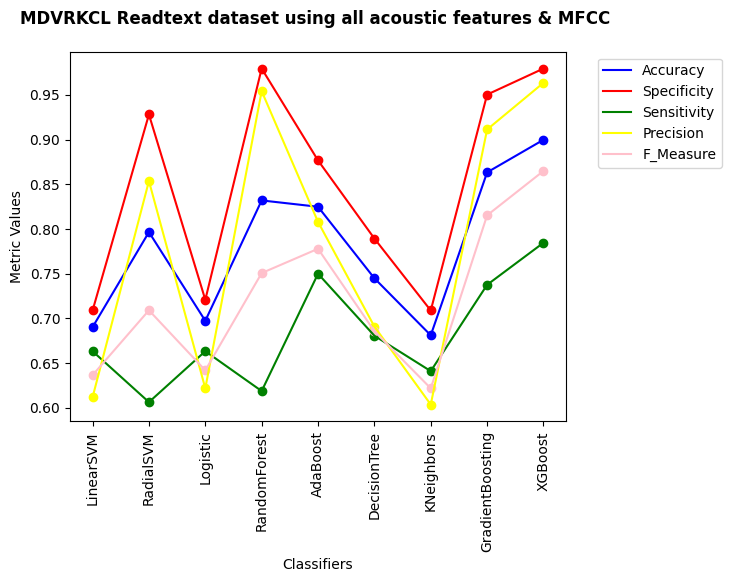

In [ ]:
plt.title("MDVRKCL Readtext dataset using all acoustic features & MFCC ",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")
plt.xticks(rotation="vertical")
plt.plot(score1['Classifier'], score1['Accuracy'], color='blue', label='Accuracy')
plt.plot(score1['Classifier'], score1['Specificity'], color='red', label='Specificity')
plt.plot(score1['Classifier'], score1['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score1['Classifier'], score1['Precision'], color='yellow', label='Precision')
plt.plot(score1['Classifier'], score1['F Measure'] , color ='pink' , label = 'F_Measure')
plt.scatter(score1['Classifier'], score1['Accuracy'], color='blue')
plt.scatter(score1['Classifier'], score1['Specificity'], color='red')
plt.scatter(score1['Classifier'], score1['Sensitivity'], color='green')
plt.scatter(score1['Classifier'], score1['Precision'], color='yellow')
plt.scatter(score1['Classifier'], score1['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
# Checking the evaluation metrices while considering all the acoustic features & MFCC  selected using genetic algorithm for MDVRKCL Readtext dataset
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(dfe)
le = LabelEncoder()
le.fit(label_pd)
label = le.transform(label_pd)

score2 = Evaluate(X_imputed,label)
score2_sorted = score2.sort_values(by="Accuracy", ascending=False)


In [ ]:
score2_sorted.reset_index(drop=True, inplace=True)
score2_sorted

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,XGBoost,0.968303,0.989673,0.937028,0.984127,0.960000
1,RandomForest,0.953988,0.989673,0.901763,0.983516,0.940867
2,KNeighbors,0.937628,0.967298,0.894207,0.949198,0.920882
3,GradientBoosting,0.927403,0.972461,0.861461,0.955307,0.905960
4,DecisionTree,0.911043,0.950086,0.853904,0.921196,0.886275
5,AdaBoost,0.883436,0.931153,0.813602,0.889807,0.850000
6,RadialSVM,0.810838,0.950086,0.607053,0.892593,0.722639
7,LinearSVM,0.805726,0.912220,0.649874,0.834951,0.730878
8,Logistic,0.778119,0.870912,0.642317,0.772727,0.701513


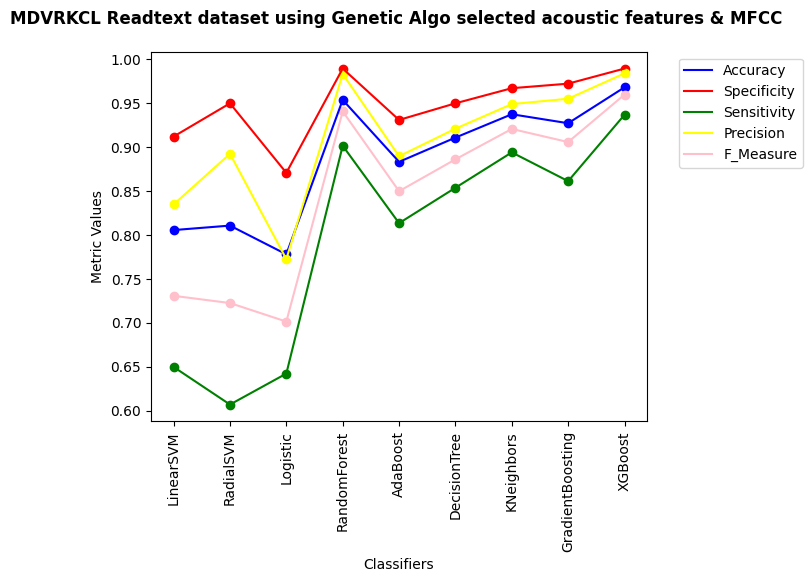

In [ ]:
plt.title("MDVRKCL Readtext dataset using Genetic Algo selected acoustic features & MFCC ",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")

plt.xticks(rotation="vertical")
plt.plot(score2['Classifier'], score2['Accuracy'], color='blue', label='Accuracy')
plt.plot(score2['Classifier'], score2['Specificity'], color='red', label='Specificity')
plt.plot(score2['Classifier'], score2['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score2['Classifier'], score2['Precision'], color='yellow', label='Precision')
plt.plot(score2['Classifier'], score2['F Measure'] , color ='pink' , label = 'F_Measure')

plt.scatter(score2['Classifier'], score2['Accuracy'], color='blue')
plt.scatter(score2['Classifier'], score2['Specificity'], color='red')
plt.scatter(score2['Classifier'], score2['Sensitivity'], color='green')
plt.scatter(score2['Classifier'], score2['Precision'], color='yellow')
plt.scatter(score2['Classifier'], score2['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [36]:
# Checking the evaluation metrices while considering all the acoustic features for MDVRKCL Spontaneous dataset

imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(dde1)
le = LabelEncoder()
le.fit(label_pd1)
label = le.transform(label_pd1)
score4 = Evaluate(X_imputed,label)
score4_sorted = score4.sort_values(by="Accuracy", ascending=False)
score4_sorted.reset_index(drop=True, inplace=True)
score4_sorted

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,XGBoost,0.835903,0.919355,0.735437,0.883382,0.802649
1,RandomForest,0.821586,0.965726,0.648058,0.940141,0.767241
2,GradientBoosting,0.820485,0.915323,0.706311,0.873874,0.781208
3,RadialSVM,0.784141,0.951613,0.582524,0.909091,0.710059
4,AdaBoost,0.774229,0.814516,0.725728,0.764706,0.744707
5,DecisionTree,0.696035,0.709677,0.679612,0.660377,0.669856
6,Logistic,0.683921,0.721774,0.638350,0.655860,0.646986
7,LinearSVM,0.676211,0.705645,0.640777,0.643902,0.642336
8,KNeighbors,0.660793,0.673387,0.645631,0.621495,0.633333


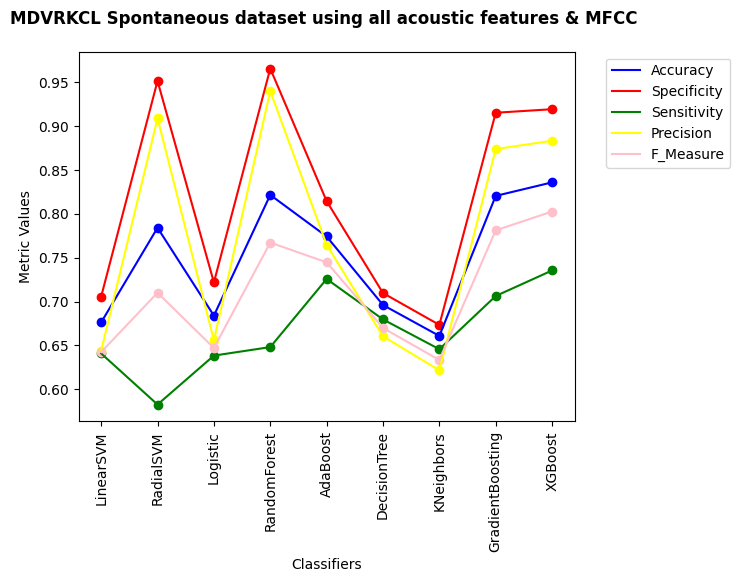

In [41]:
plt.title("MDVRKCL Spontaneous dataset using all acoustic features & MFCC ",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")
plt.xticks(rotation="vertical")
plt.plot(score4['Classifier'], score4['Accuracy'], color='blue', label='Accuracy')
plt.plot(score4['Classifier'], score4['Specificity'], color='red', label='Specificity')
plt.plot(score4['Classifier'], score4['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score4['Classifier'], score4['Precision'], color='yellow', label='Precision')
plt.plot(score4['Classifier'], score4['F Measure'] , color ='pink' , label = 'F_Measure')
plt.scatter(score4['Classifier'], score4['Accuracy'], color='blue')
plt.scatter(score4['Classifier'], score4['Specificity'], color='red')
plt.scatter(score4['Classifier'], score4['Sensitivity'], color='green')
plt.scatter(score4['Classifier'], score4['Precision'], color='yellow')
plt.scatter(score4['Classifier'], score4['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [38]:
# Checking the evaluation metrices while considering all the acoustic features selected using genetic algorithm for MDVRKCL Spontaneous dataset
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(dfe1)
le = LabelEncoder()
le.fit(label_pd1)
label = le.transform(label_pd1)
score5 = Evaluate(X_imputed,label)
score5_sorted = score5.sort_values(by="Accuracy", ascending=False)
score5_sorted.reset_index(drop=True, inplace=True)
score5_sorted

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,XGBoost,0.833700,0.919355,0.730583,0.882698,0.799469
1,GradientBoosting,0.816079,0.911290,0.701456,0.867868,0.775839
2,RandomForest,0.799559,0.941532,0.628641,0.899306,0.740000
3,RadialSVM,0.774229,0.945565,0.567961,0.896552,0.695394
4,AdaBoost,0.766520,0.814516,0.708738,0.760417,0.733668
5,DecisionTree,0.720264,0.760081,0.672330,0.699495,0.685644
6,Logistic,0.681718,0.729839,0.623786,0.657289,0.640100
7,KNeighbors,0.657489,0.667339,0.645631,0.617169,0.631079
8,LinearSVM,0.647577,0.665323,0.626214,0.608491,0.617225


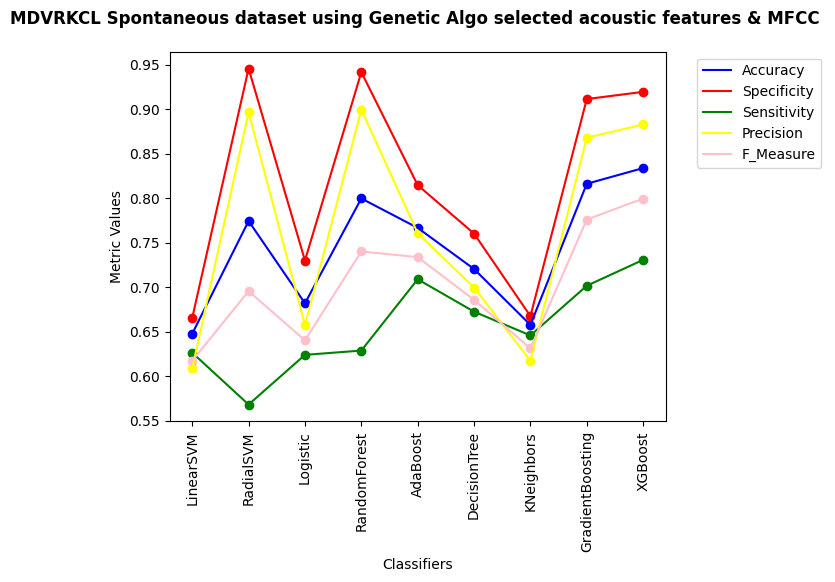

In [42]:
plt.title("MDVRKCL Spontaneous dataset using Genetic Algo selected acoustic features & MFCC ",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")
plt.xticks(rotation="vertical")
plt.plot(score5['Classifier'], score5['Accuracy'], color='blue', label='Accuracy')
plt.plot(score5['Classifier'], score5['Specificity'], color='red', label='Specificity')
plt.plot(score5['Classifier'], score5['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score5['Classifier'], score5['Precision'], color='yellow', label='Precision')
plt.plot(score5['Classifier'], score5['F Measure'] , color ='pink' , label = 'F_Measure')
plt.scatter(score5['Classifier'], score5['Accuracy'], color='blue')
plt.scatter(score5['Classifier'], score5['Specificity'], color='red')
plt.scatter(score5['Classifier'], score5['Sensitivity'], color='green')
plt.scatter(score5['Classifier'], score5['Precision'], color='yellow')
plt.scatter(score5['Classifier'], score5['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
